# PREDICTING DOLLAR PRICES

**Цель:** Прогноз курса доллар/гривна на день, неделю и месяц. Поиск сезонных закономерностей.

**Задача:** Прогнозирование временных рядов. Метрики качества - MAPE, MSE.

Datasets: api.privatbank.ua

# Import libraries 

In [1]:
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from fbprophet import Prophet
from datetime import datetime, date, time

import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.special import inv_boxcox
from scipy import stats




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Data

## Import Data. Api Privatbank.

In [ ]:
# собираем курсы валют с помощью api Privatbank с 01.01.2015 по 23.08.2021

url = 'https://api.privatbank.ua/p24api/exchange_rates?json&date=01.01.2015'
df = pd.read_json(url, lines=True,orient='columns')

dt = pd.date_range(start="2015-01-02",end="2021-08-23")

for i in dt:
  d = i.strftime('%d')
  m = i.strftime('%m')
  y = i.strftime('%y')
  url = f'https://api.privatbank.ua/p24api/exchange_rates?json&date={d}.{m}.20{y}'
  df_n = pd.read_json(url, lines=True,orient='columns')
  df = pd.concat([df, df_n], sort=False)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Функция для извлечения из exchangeRate необходимой информации(валюта, курс НБУ, курс покупки/продажи USD/UAH Приватбанка)

def curr_usd(list_d):
  for i in range(0,len(list_d)):
    if 'currency' in list_d[i]:
      if list_d[i]['currency'] == 'USD':
        if 'purchaseRate' in list_d[i]:
          return list_d[i]['currency'], list_d[i]['saleRateNB'], list_d[i]['purchaseRate'], list_d[i]['saleRate']
        else:
          return list_d[i]['currency'], list_d[i]['saleRateNB'], list_d[i]['purchaseRateNB'], list_d[i]['saleRateNB']+0.2

In [ ]:
df_e1 = pd.DataFrame(df)



In [ ]:
df_e1['currency'] = df_e1['exchangeRate'].apply(lambda x: curr_usd(x)[0])
df_e1['nbu'] = df_e1['exchangeRate'].apply(lambda x: curr_usd(x)[1])
df_e1['purchase'] = df_e1['exchangeRate'].apply(lambda x: curr_usd(x)[2])
df_e1['sale'] = df_e1['exchangeRate'].apply(lambda x: curr_usd(x)[3])

In [ ]:
df_e1.head()

In [ ]:
df_e1['date_f'] = pd.date_range(start="2015-01-01",end="2021-08-23")

In [ ]:
df_sale = pd.DataFrame(df_e1[['date_f', 'sale']])
df_sale

## Import Data. CSV file.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/pb_1521_sale.csv')

In [5]:
df.head()

,Unnamed: 0,date_f,sale
0,0,2015-01-01,16.53
1,0,2015-01-02,16.53
2,0,2015-01-03,16.53
3,0,2015-01-04,16.53
4,0,2015-01-05,16.53


In [6]:
df.drop(axis=1, columns=['Unnamed: 0'],inplace=True)
df.head()

,date_f,sale
0,2015-01-01,16.53
1,2015-01-02,16.53
2,2015-01-03,16.53
3,2015-01-04,16.53
4,2015-01-05,16.53


#Data analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date_f  2427 non-null   object 
 1   sale    2427 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.0+ KB


Пропусков нет.

In [8]:
df.describe()

,sale
count,2427.000000
mean,26.316498
std,1.958314
min,16.520000
25%,25.350000
50%,26.700000
75%,27.630000
max,33.500000


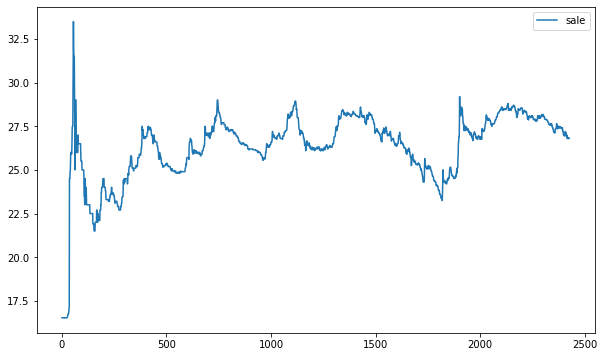

In [9]:
df.plot(figsize=(10,6));

Используем правило 3-х сигм, чтобы найти более точные границы интервалов для аномальных значений в данных. Будем считать: всё что оказалось за пределами трёх сигм - аномалия.

In [10]:
def outlier_std(data, col, threshold=3):
    """
        Вычисляет для каждой строки является ли она аномалией
    """
    
    mean = data[col].mean()
    std = data[col].std()
    
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1)
    return anomalies, up_bound, low_bound

In [11]:
a,l,r = outlier_std(df, 'sale')

In [12]:
df_an = df
df_an['Anomal'] = a

In [13]:
df_an.head()

,date_f,sale,Anomal
0,2015-01-01,16.53,True
1,2015-01-02,16.53,True
2,2015-01-03,16.53,True
3,2015-01-04,16.53,True
4,2015-01-05,16.53,True


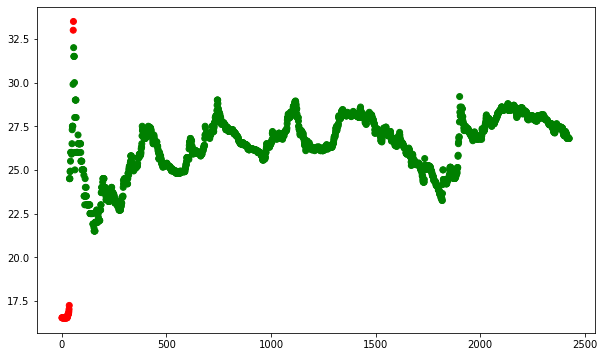

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(df_an.index, df_an.sale, 
            c = df_an['Anomal'].apply(lambda x: 'r' if x == True else 'g'))

График показывает, что все аномальные значения находятся вначале списка(вначале 2015года). Найдем количество аномальных значений и последнюю дату, когда они встречаются.
  

In [15]:
# количество аномальных значений
df_an['Anomal'].sum()

38

In [16]:
# найдем дату после которой не встречаются аномальные значения.

df_an[df_an['Anomal']==True].sort_values(by=['date_f'],ascending=False).head(1)

,date_f,sale,Anomal
55,2015-02-25,33.5,True


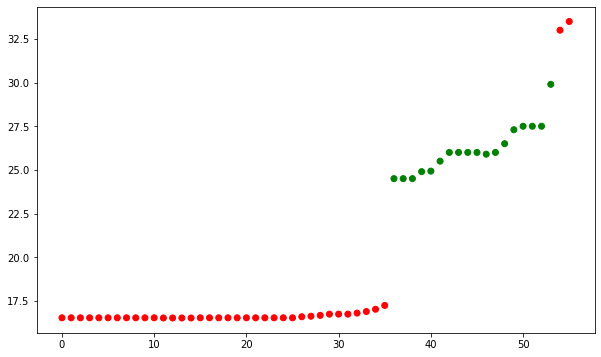

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(df_an.index[:56], df_an.sale[:56], 
            c = df_an['Anomal'][:56].apply(lambda x: 'r' if x == True else 'g'))

До 2015-02-25 встречаются данные и без аномалий. Для точного прогнозирования временных рядов нужные данные без пропусков, поэтому для прогноза без сильной волатильности будем использовать данные после 2015-02-25 (index>56)

Сравним основные показатели данных с выбросами и без них.

In [18]:
df_rep = df.describe()
df_rep['sale_not_anomal'] = df[56:].describe()
df_rep['sale_diff'] = df_rep['sale_not_anomal'] - df_rep['sale']
df_rep['sale_diff_%'] = ((df_rep['sale_not_anomal'] - df_rep['sale'])/df_rep['sale']) *100
df_rep

,sale,sale_not_anomal,sale_diff,sale_diff_%
count,2427.000000,2371.000000,-56.000000,-2.307375
mean,26.316498,26.459267,0.142769,0.542507
std,1.958314,1.554886,-0.403428,-20.600794
min,16.520000,21.500000,4.980000,30.145278
25%,25.350000,25.500000,0.150000,0.591716
50%,26.700000,26.750000,0.050000,0.187266
75%,27.630000,27.650000,0.020000,0.072385
max,33.500000,32.000000,-1.500000,-4.477612


Результаты сравнения:
- среднее значение увеличилось незначительно на 0,54%
- медиана увеличилось незначительно на 0,19%
- стандартное отклонение уменьшилось на 20,6%
- минимальное значение увеличилось на 30,15%
- максимальное значение снизилось на 4,48% 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



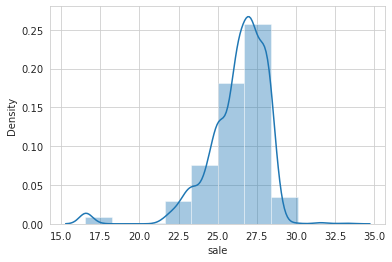

In [19]:
# посмотрим на график плотности распределения
sns.set_style('whitegrid')
sns.distplot(df['sale'], bins=10);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



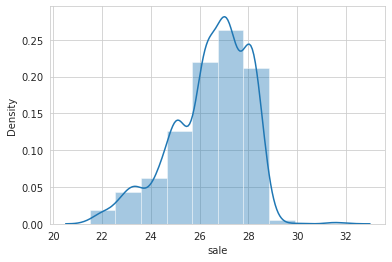

In [20]:
# посмотрим на график плотности распределения без аномальных значений начала 2015 года

sns.set_style('whitegrid')
sns.distplot(df['sale'][56:], bins=10);

In [21]:
df_an['year'] = df['date_f'].apply(lambda x: x[:4])
df_an.head()

,date_f,sale,Anomal,year
0,2015-01-01,16.53,True,2015
1,2015-01-02,16.53,True,2015
2,2015-01-03,16.53,True,2015
3,2015-01-04,16.53,True,2015
4,2015-01-05,16.53,True,2015


In [22]:
# Проверим гипотезу о нормальном распределении данных тестом Колмогорова

stats.kstest(df_an['sale'], 'norm', 
             args=(df_an['sale'].mean(), df_an['sale'].std(ddof=1)))

KstestResult(statistic=0.12471986439975091, pvalue=2.3036815494823144e-33)

Гипотеза о нормальности отвергается, p_value оказалось очень маленьким.

In [23]:
# Проверим гипотезу о нормальном распределении данных тестом Колмогорова для каждого года в отдельности

for i in df_an['year'].unique():
  df_i = df_an[df_an['year']== i]['sale']
  ktest_r = stats.kstest(df_i, 'norm', args=(df_i.mean(), df_i.std(ddof=1)))
  print(f'{i}г.: p-value={ktest_r[1]}')

2015г.: p-value=1.6874529084615193e-11
2016г.: p-value=0.0001659823052943094
2017г.: p-value=0.009742808450151276
2018г.: p-value=1.558467257258748e-13
2019г.: p-value=0.0045515689713888875
2020г.: p-value=7.818463447871147e-10
2021г.: p-value=0.0003119590870854064


Гипотеза о нормальности отвергается, все p_value оказались очень маленькими.

In [24]:
# Посмотрим на основные статистическое показатели в разрезе каждого года

df_rep_y = pd.DataFrame()
for i in df_an['year'].unique():
  df_rep_y[i] = df_an[df_an['year']== i]['sale'].describe()

df_rep_y

,2015,2016,2017,2018,2019,2020,2021
count,365.000000,366.000000,365.000000,365.000000,365.000000,366.000000,235.000000
mean,23.507614,26.044317,26.877731,27.323973,26.019808,27.206038,27.742043
std,2.893886,0.849794,0.725864,0.905078,1.249316,1.379859,0.448496
min,16.520000,24.810000,25.550000,26.100000,23.250000,24.200000,26.800000
25%,22.700000,25.250000,26.300000,26.300000,25.100000,26.850000,27.400000
50%,23.600000,26.000000,26.850000,27.500000,26.250000,27.615000,27.860000
75%,25.100000,26.900000,27.300000,28.150000,27.000000,28.410000,28.050000
max,33.500000,27.700000,29.000000,28.950000,28.300000,29.200000,28.550000


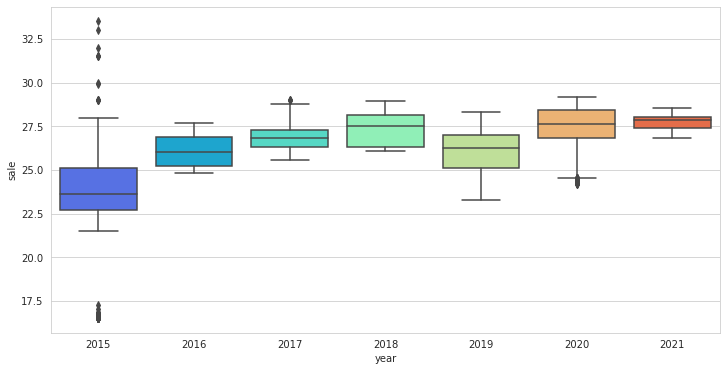

In [25]:
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(x="year", y="sale", data=df_an, palette='rainbow');

In [26]:
df_an['month'] = df['date_f'].apply(lambda x: x[5:7])
df_an.head()

,date_f,sale,Anomal,year,month
0,2015-01-01,16.53,True,2015,01
1,2015-01-02,16.53,True,2015,01
2,2015-01-03,16.53,True,2015,01
3,2015-01-04,16.53,True,2015,01
4,2015-01-05,16.53,True,2015,01


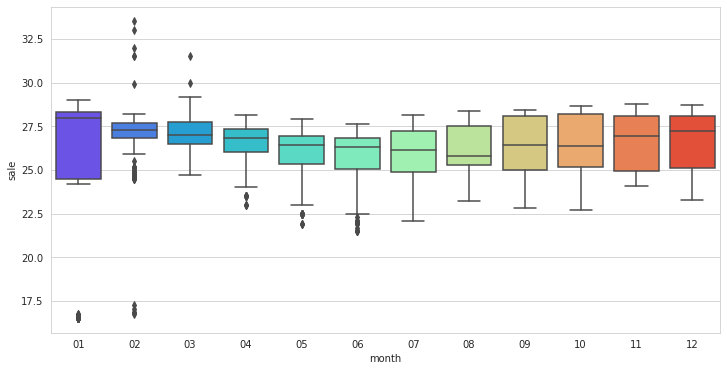

In [27]:
# Посмотрим на месячные  статистические данные в разрезе года. 

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(x="month", y="sale", data=df_an, palette='rainbow');

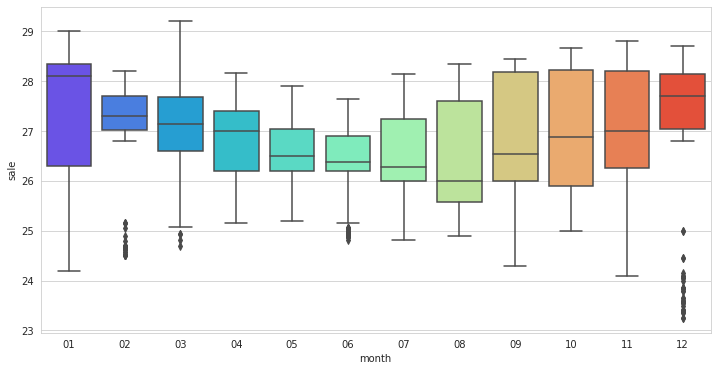

In [28]:
# Посмотрим на месячные  статистические данные в разрезе года. 
# Чтобы уменьшить влияние выбросов откинем 2015 год.

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(x="month", y="sale", data=df_an[df_an['year'] != '2015'], palette='rainbow');

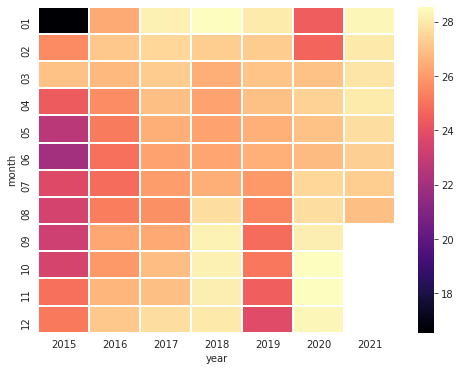

In [29]:
plt.figure(figsize=(8, 6))
df_an_m_y = df_an.pivot_table(
    values='sale', index='month', columns='year')

sns.heatmap(df_an_m_y, cmap='magma', linecolor='white', linewidths=1);

In [30]:
df_an['day_m'] = df['date_f'].apply(lambda x: x[8:10])
df_an.head()

,date_f,sale,Anomal,year,month,day_m
0,2015-01-01,16.53,True,2015,01,01
1,2015-01-02,16.53,True,2015,01,02
2,2015-01-03,16.53,True,2015,01,03
3,2015-01-04,16.53,True,2015,01,04
4,2015-01-05,16.53,True,2015,01,05


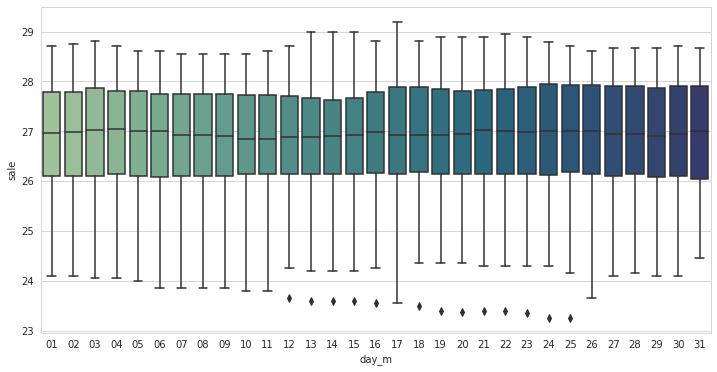

In [31]:
# Посмотрим на дневные статистические данные в разрезе месяца. 
# Чтобы уменьшить влияние выбросов откинем 2015 год.

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(x="day_m", y="sale", 
            data=df_an[df_an['year'] != '2015'], 
            palette='crest');

Пропусков в данных нет.

Гипотеза о нормальном распределении отвергается, p_value оказалось очень маленьким.

2015 год имеет самую сильную волантильность(самые экстремальные значения std, min, max).

Прослеживается сезонное снижение курса во втором квартале.


#Modeling

## Обучаем модель без параметров

In [32]:
prophet_df = df[['date_f','sale']].rename(columns={'date_f':'ds', 'sale':'y'})

In [33]:
prophet_df.head()

,ds,y
0,2015-01-01,16.53
1,2015-01-02,16.53
2,2015-01-03,16.53
3,2015-01-04,16.53
4,2015-01-05,16.53


In [34]:
m = Prophet()
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
# Forcasting into the future
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

In [36]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2512,2021-11-17,27.995616,26.882213,29.538531,27.095553,28.657035,0.320777,0.320777,0.320777,-0.001812,-0.001812,-0.001812,0.322589,0.322589,0.322589,0.0,0.0,0.0,28.316393
2513,2021-11-18,27.995846,26.971471,29.668079,27.072678,28.669713,0.332426,0.332426,0.332426,-0.005941,-0.005941,-0.005941,0.338367,0.338367,0.338367,0.0,0.0,0.0,28.328272
2514,2021-11-19,27.996077,26.769963,29.714007,27.053544,28.680055,0.358958,0.358958,0.358958,0.004646,0.004646,0.004646,0.354312,0.354312,0.354312,0.0,0.0,0.0,28.355035
2515,2021-11-20,27.996307,26.908318,29.702960,27.032117,28.690396,0.379263,0.379263,0.379263,0.009147,0.009147,0.009147,0.370115,0.370115,0.370115,0.0,0.0,0.0,28.375570
2516,2021-11-21,27.996538,26.881765,29.728608,27.003500,28.703262,0.390082,0.390082,0.390082,0.004630,0.004630,0.004630,0.385452,0.385452,0.385452,0.0,0.0,0.0,28.386619


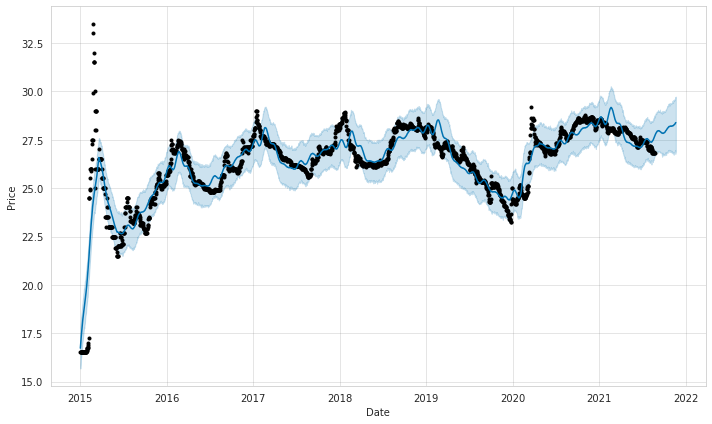

In [37]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

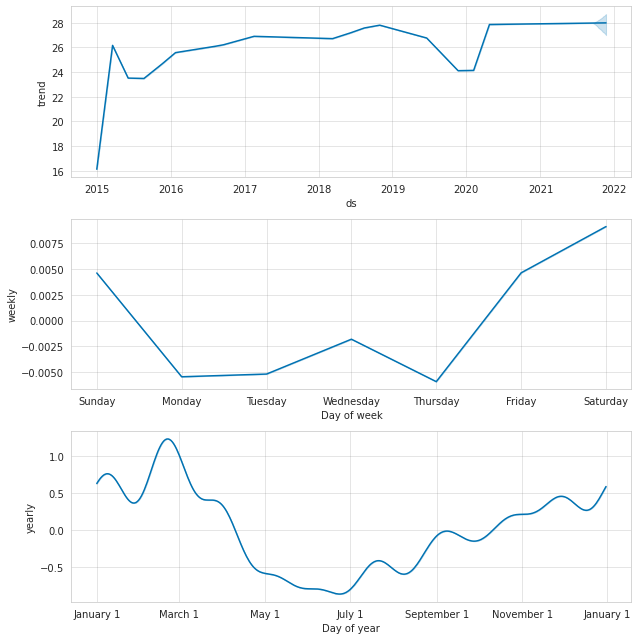

In [38]:
figure3 = m.plot_components(forecast)

## Добавим параметр сезонности и праздники


In [39]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(prophet_df)

# Forcasting into the future
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
m.train_holiday_names


0                                  Новий рік
1              Різдво Христове (православне)
2                   Міжнародний жіночий день
3     День міжнародної солідарності трудящих
4                          Пасха (Великдень)
5                                     Трійця
6                              День перемоги
7                   День Конституції України
8                  День незалежності України
9                     День захисника України
10              Різдво Христове (католицьке)
11                                День праці
dtype: object

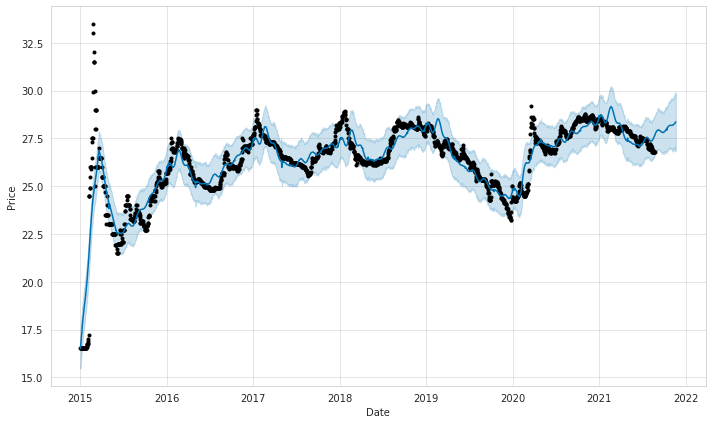

In [41]:
figure = m.plot(forecast, xlabel='Date', ylabel='Price')

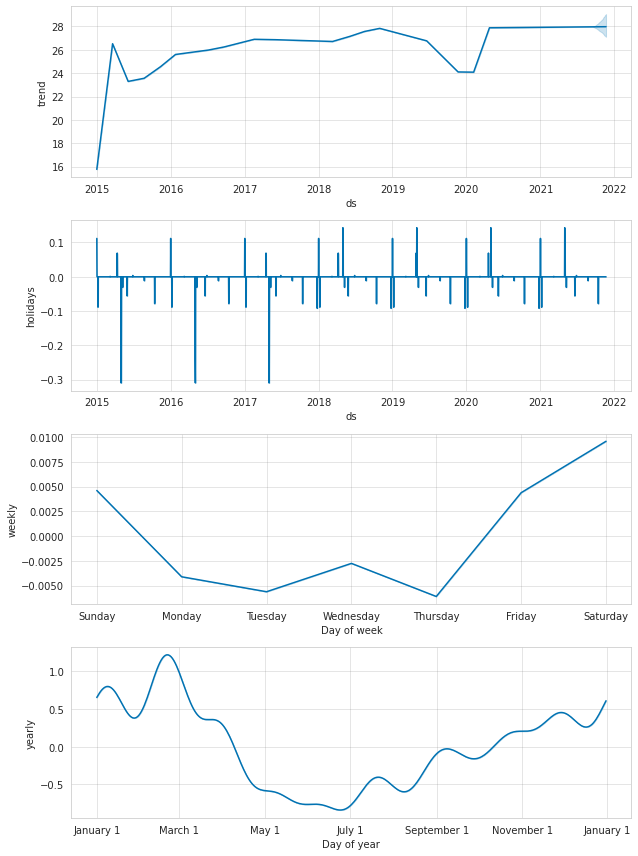

In [42]:
figure3 = m.plot_components(forecast)

## Посчитаем ошибку модели 

## Расчет ошибки базовой модели

In [43]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[:-predictions]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


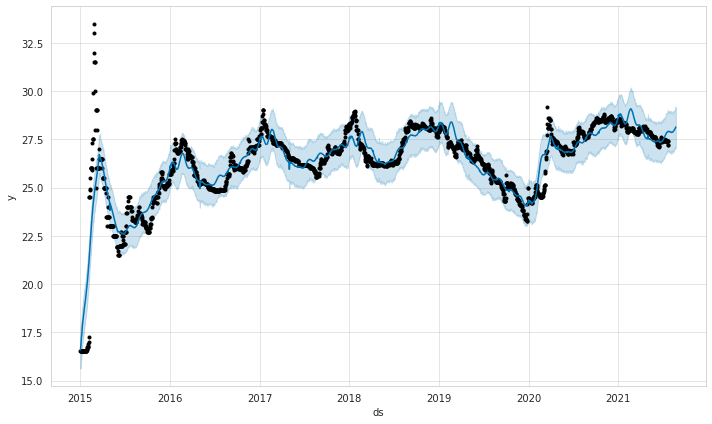

In [44]:
# Смотрим, что предсказалось
m.plot(forecast);

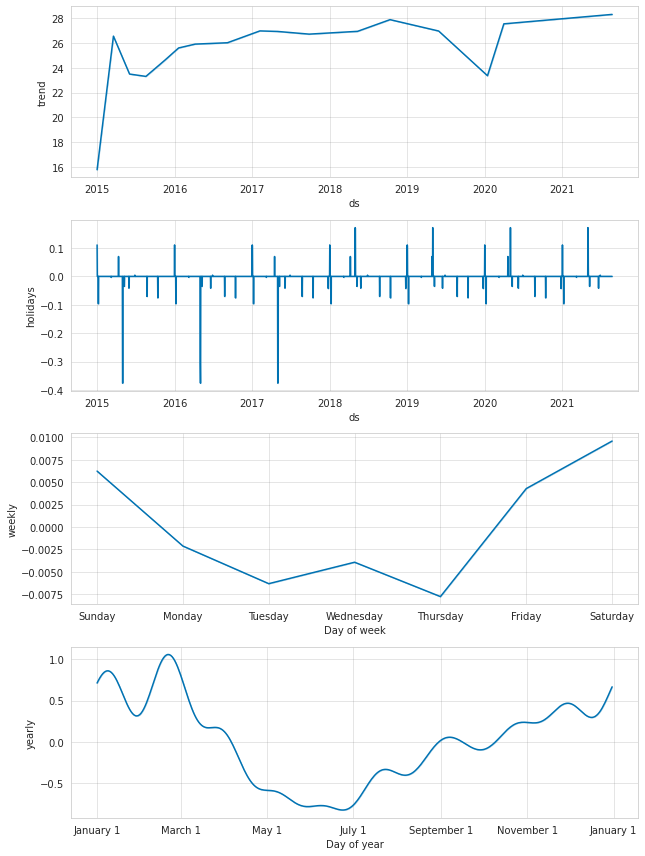

In [45]:
figure3 = m.plot_components(forecast)

In [46]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(prophet_df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  3.603646992799116 %
MAE (средняя абсолютная ошибка) –  0.9707497265136239


## Расчет ошибки модели без сильной волатильности начала 2015года

In [47]:
# отбрасываем сильную волатильность вначале 2015года
start_p = 56

In [48]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:-predictions]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


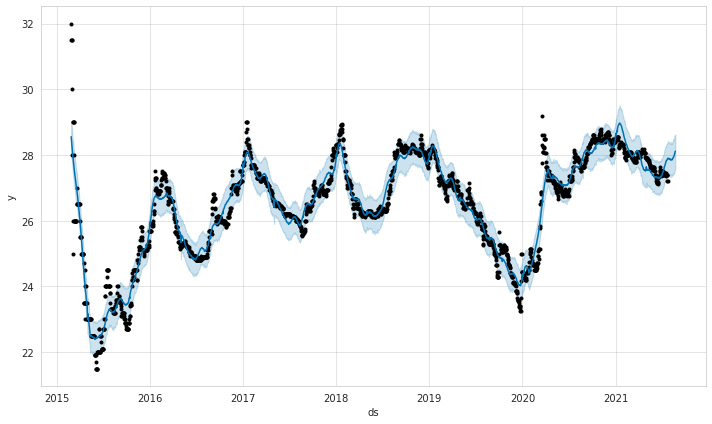

In [49]:
# Смотрим, что предсказалось
m.plot(forecast);

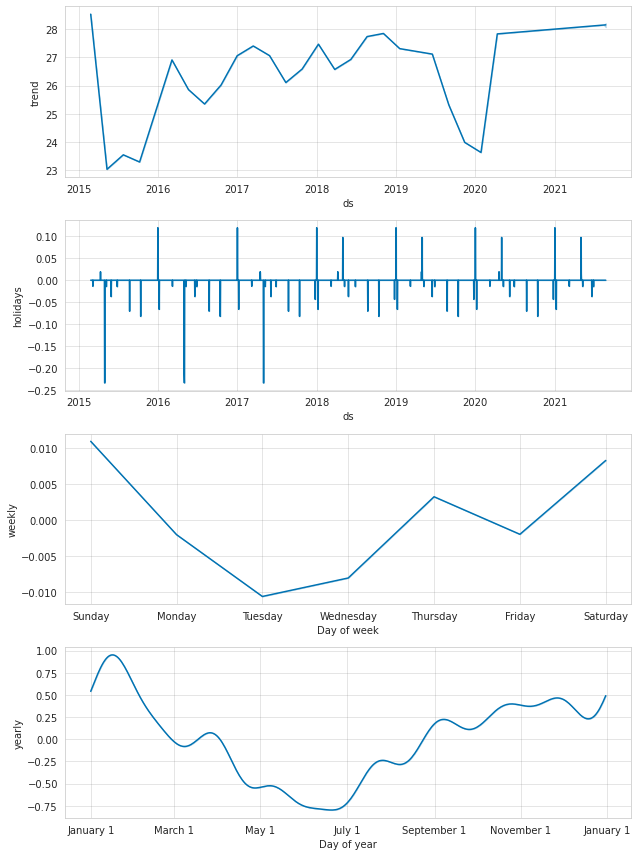

In [50]:
figure3 = m.plot_components(forecast)

In [51]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(prophet_df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  3.536959763583608 %
MAE (средняя абсолютная ошибка) –  0.952802304052978


In [52]:
cmp_df

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2015-02-26,28.560015,28.061370,29.032537,32.00,3.439985,10.749954
2015-02-27,28.464501,27.912636,28.953031,31.50,3.035499,9.636504
2015-02-28,28.385403,27.866073,28.881114,31.50,3.114597,9.887610
2015-03-01,28.299806,27.834327,28.868099,31.50,3.200194,10.159346
2015-03-02,28.199863,27.729259,28.725999,30.00,1.800137,6.000458
...,...,...,...,...,...,...
2021-08-19,28.015158,27.490568,28.574918,26.85,-1.165158,-4.339507
2021-08-20,28.035556,27.493066,28.570409,26.80,-1.235556,-4.610282
2021-08-21,28.072446,27.571461,28.620551,26.80,-1.272446,-4.747933


##Расчет ошибки модели на данных 2017-2021гг.

In [53]:
# отбрасываем 2015 и 2016 год
start_p = 731

In [54]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:-predictions]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


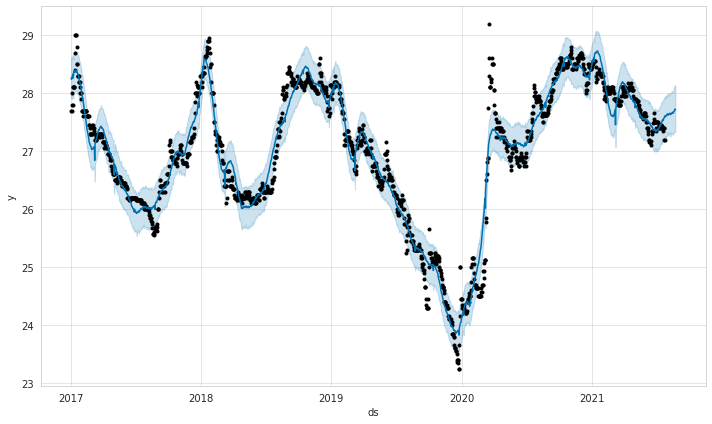

In [55]:
# Смотрим, что предсказалось
m.plot(forecast);

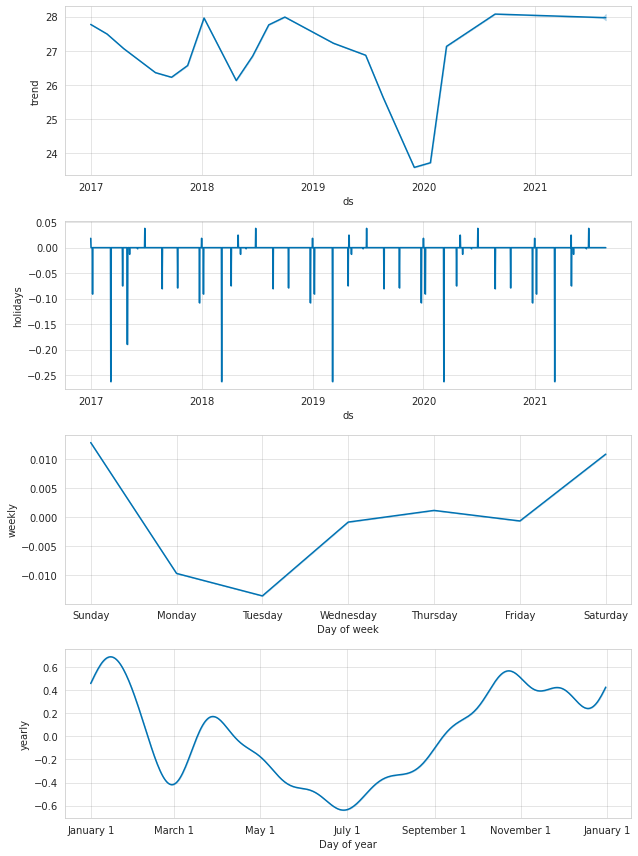

In [56]:
figure3 = m.plot_components(forecast)

In [57]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(prophet_df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  2.5354629471378574 %
MAE (средняя абсолютная ошибка) –  0.6828906372718995


##Расчет ошибки модели на данных 2019-2021гг.

In [58]:
# отбрасываем 2015, 2016, 2017, 2018 год
start_p = 1461

In [59]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:-predictions]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


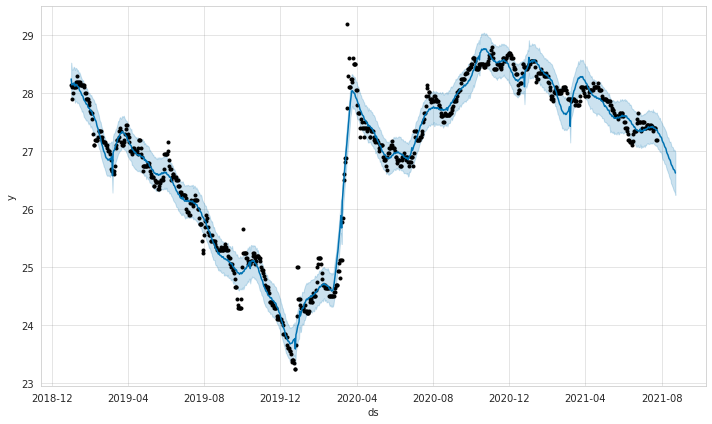

In [60]:
# Смотрим, что предсказалось
m.plot(forecast);

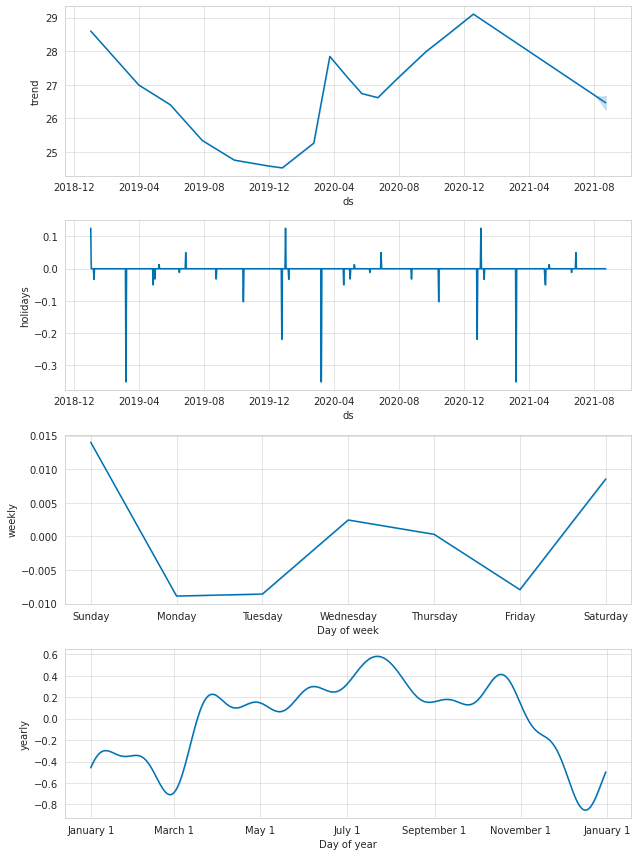

In [61]:
figure3 = m.plot_components(forecast)

In [62]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(prophet_df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  0.4750417230939838 %
MAE (средняя абсолютная ошибка) –  0.12810864137272138


In [63]:
cmp_df

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2019-01-01,28.245985,27.955240,28.527209,28.15,-0.095985,-0.340979
2019-01-02,28.143637,27.901395,28.415609,28.10,-0.043637,-0.155292
2019-01-03,28.151521,27.883591,28.404344,27.90,-0.251521,-0.901511
2019-01-04,28.150628,27.874349,28.419974,28.00,-0.150628,-0.537959
2019-01-05,28.171513,27.911075,28.456956,28.10,-0.071513,-0.254496
...,...,...,...,...,...,...
2021-08-19,26.716135,26.367953,27.066296,26.85,0.133865,0.498566
2021-08-20,26.684831,26.329662,27.011137,26.80,0.115169,0.429736
2021-08-21,26.679630,26.313416,27.029681,26.80,0.120370,0.449142


## Прогноз на 30 дней по данным 2019-2021гг.


In [64]:
# отбрасываем 2015, 2016, 2017, 2018 год
start_p = 1461

In [65]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m.add_country_holidays(country_name='UA')
m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


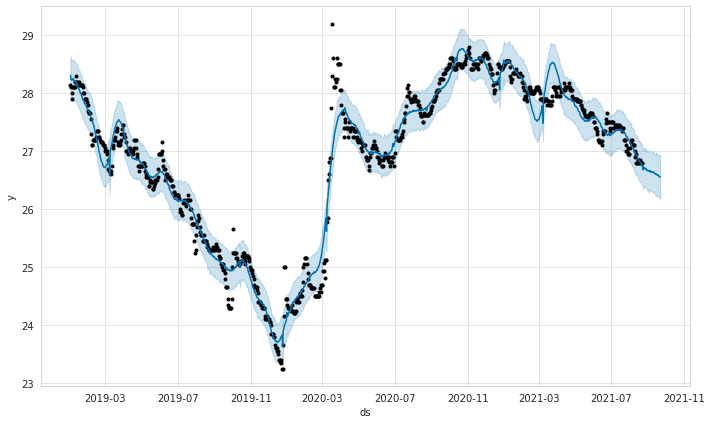

In [66]:
# Смотрим, что предсказалось
m.plot(forecast);

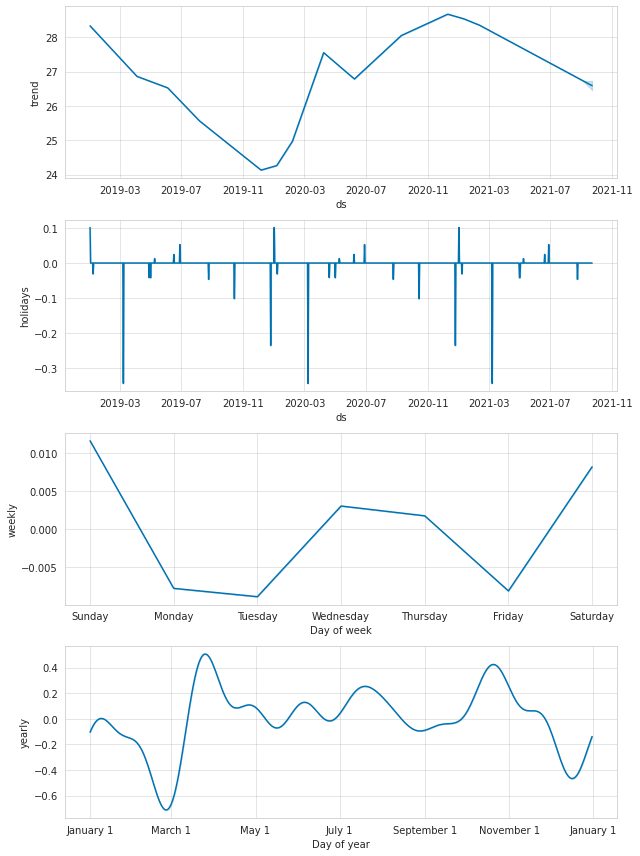

In [67]:
figure3 = m.plot_components(forecast)

In [68]:
forecast[967:].head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,День Конституції України,День Конституції України_lower,День Конституції України_upper,День захисника України,День захисника України_lower,День захисника України_upper,День незалежності України,День незалежності України_lower,День незалежності України_upper,День перемоги,День перемоги_lower,День перемоги_upper,День праці,День праці_lower,День праці_upper,Міжнародний жіночий день,Міжнародний жіночий день_lower,Міжнародний жіночий день_upper,Новий рік,Новий рік_lower,Новий рік_upper,Пасха (Великдень),Пасха (Великдень)_lower,Пасха (Великдень)_upper,Різдво Христове (католицьке),Різдво Христове (католицьке)_lower,Різдво Христове (католицьке)_upper,Різдво Христове (православне),Різдво Христове (православне)_lower,Різдво Христове (православне)_upper,Трійця,Трійця_lower,Трійця_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
967,2021-08-25,26.812548,26.393199,27.052247,26.812548,26.812548,-0.086517,-0.086517,-0.086517,0.0,0.0,0.0,0.003072,0.003072,0.003072,-0.089590,-0.089590,-0.089590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.726030
968,2021-08-26,26.804643,26.399037,27.026433,26.804643,26.804643,-0.090913,-0.090913,-0.090913,0.0,0.0,0.0,0.001783,0.001783,0.001783,-0.092696,-0.092696,-0.092696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.713730
969,2021-08-27,26.796738,26.374187,27.006169,26.796738,26.796738,-0.102786,-0.102786,-0.102786,0.0,0.0,0.0,-0.008112,-0.008112,-0.008112,-0.094674,-0.094674,-0.094674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.693952
970,2021-08-28,26.788833,26.369117,27.061533,26.788833,26.788833,-0.087314,-0.087314,-0.087314,0.0,0.0,0.0,0.008238,0.008238,0.008238,-0.095552,-0.095552,-0.095552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.701520
971,2021-08-29,26.780929,26.363858,27.036579,26.780929,26.780929,-0.083712,-0.083712,-0.083712,0.0,0.0,0.0,0.011666,0.011666,0.011666,-0.095378,-0.095378,-0.095378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.697216
972,2021-08-30,26.773024,26.355201,27.012655,26.773024,26.773024,-0.102000,-0.102000,-0.102000,0.0,0.0,0.0,-0.007774,-0.007774,-0.007774,-0.094225,-0.094225,-0.094225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.671024
973,2021-08-31,26.765119,26.318249,26.990780,26.764798,26.765119,-0.101057,-0.101057,-0.101057,0.0,0.0,0.0,-0.008872,-0.008872,-0.008872,-0.092184,-0.092184,-0.092184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.664062
974,2021-09-01,26.757214,26.344981,27.002245,26.755216,26.757428,-0.086293,-0.086293,-0.086293,0.0,0.0,0.0,0.003072,0.003072,0.003072,-0.089365,-0.089365,-0.089365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.670922
975,2021-09-02,26.749309,26.335176,26.992131,26.744186,26.751097,-0.084110,-0.084110,-0.084110,0.0,0.0,0.0,0.001783,0.001783,0.001783,-0.085893,-0.085893,-0.085893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.665199
976,2021-09-03,26.741405,26.275499,26.987581,

## Поиск оптимальных параметров

Попробуем кросвалидацию

In [69]:
start_p = 1461
# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:]

m = Prophet(weekly_seasonality='auto', yearly_seasonality='auto')
m.add_country_holidays(country_name='UA')
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
df_cv = cross_validation(m, initial='366 days', period='60 days', horizon = '120 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

In [71]:
df_p = performance_metrics(df_cv, rolling_window=0.1)

In [72]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,12 days,0.238900,0.488774,0.357137,0.013038,0.009448,0.500000
1,13 days,0.293594,0.541843,0.398486,0.014528,0.010175,0.468750
2,14 days,0.348893,0.590672,0.438150,0.015952,0.011365,0.447917
3,15 days,0.443985,0.666322,0.486288,0.017664,0.013307,0.416667
4,16 days,0.644596,0.802867,0.553807,0.020006,0.015128,0.375000
...,...,...,...,...,...,...,...
104,116 days,7.713157,2.777257,2.297448,0.082775,0.068009,0.312500
105,117 days,7.703841,2.775579,2.295731,0.082707,0.068009,0.312500
106,118 days,7.696773,2.774306,2.293740,0.082630,0.068191,0.312500
107,119 days,7.702943,2.775418,2.294315,0.082629,0.070821,0.312500


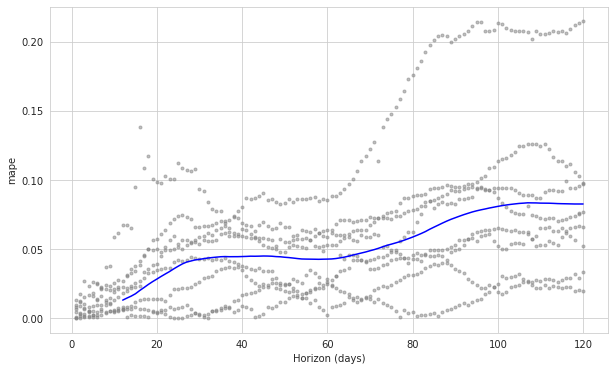

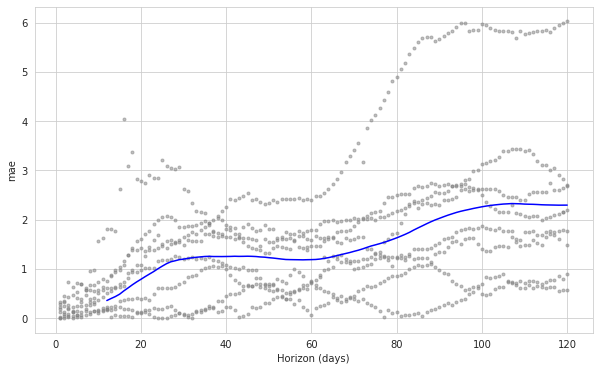

In [73]:
fig1 = plot_cross_validation_metric(df_cv, metric='mape')
fig2 = plot_cross_validation_metric(df_cv, metric='mae')

Применим кроссвалидацию и подбор параметров

In [74]:
predictions = 30

start_p = 1461
# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = prophet_df[start_p:]



# применим подбор параметров

param_grid = {
    'n_changepoints': range(10, 30, 1),
    'changepoint_prior_scale': [0.025, 0.05, 0.1]
}

# создаем все комбинации параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

# запускаем кросвалидацию со всеми комбинациями параметров
for params in all_params:
  m = Prophet(**params, weekly_seasonality=True, yearly_seasonality=True)
  m.fit(train_df)
  df_cv = cross_validation(m, initial='366 days', period='60 days', horizon = '120 days')
  df_p = performance_metrics(df_cv, rolling_window=1)
  mapes.append(df_p['mape'].values[0])

# смотрим на результаты с разными параметрами
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-01 00:00:00 and 2021-04-25 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

    n_changepoints  changepoint_prior_scale      mape
0               10                    0.025  0.046187
1               10                    0.050  0.042146
2               10                    0.100  0.051831
3               11                    0.025  0.055945
4               11                    0.050  0.054420
5               11                    0.100  0.052725
6               12                    0.025  0.048615
7               12                    0.050  0.047452
8               12                    0.100  0.051252
9               13                    0.025  0.049930
10              13                    0.050  0.055608
11              13                    0.100  0.060731
12              14                    0.025  0.048813
13              14                    0.050  0.053227
14              14                    0.100  0.053642
15              15                    0.025  0.041720
16              15                    0.050  0.050113
17              15          

In [75]:
# посмотрим на лучшие параметры
best_params = all_params[np.argmin(mapes)]
best_params

{'changepoint_prior_scale': 0.05, 'n_changepoints': 20}

##Прогноз на 60 дней с оптимальными параметрами 

In [76]:
# отбрасываем 2015, 2016, 2017, 2018 год
start_p = 1461

predictions = 60

train_df = prophet_df[start_p:]

# Настраиваем prophet – говорим ему учитывать праздники и сезонности
m = Prophet(weekly_seasonality=True, yearly_seasonality=True,
            n_changepoints=20, changepoint_prior_scale=0.05)

m.fit(train_df)

# Предсказываем predictions-дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


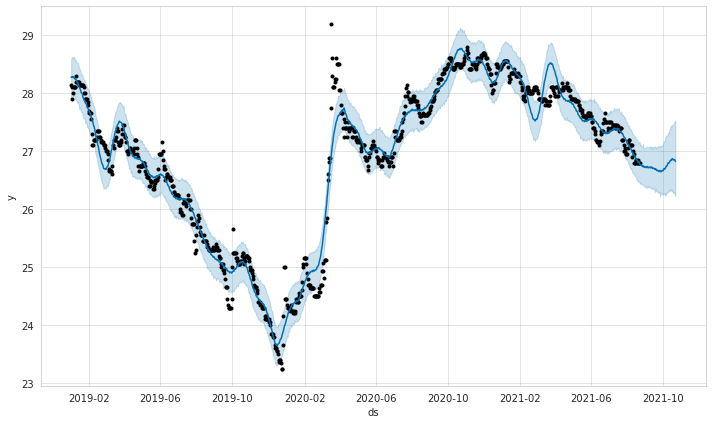

In [77]:
m.plot(forecast);

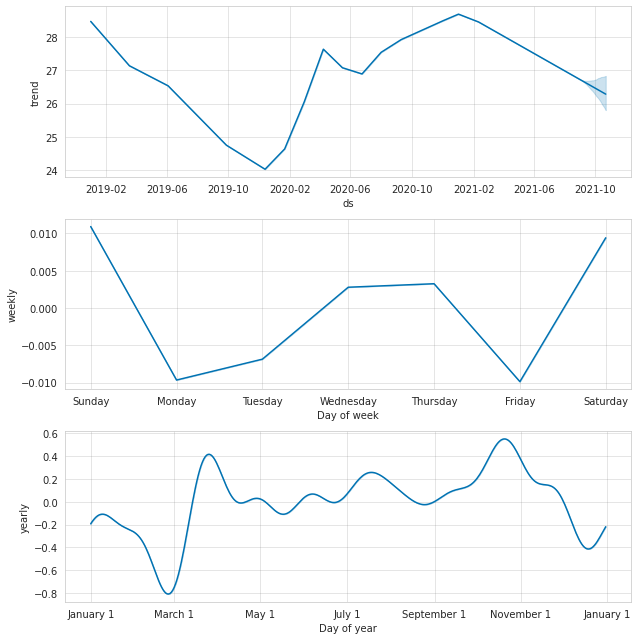

In [78]:
figure3 = m.plot_components(forecast)